In [34]:
# Basic imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Model imports
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor

# Data processing

We start by importing our processed data, which had removed some features we deemed irrelevant for our purposes and translated textual data to numeric values. The exact mapping of textual to numeric values is noted in a later cell, but they won't matter for training the models. The numeric representation suffices for distinguishing these features from each other.

Once the data is imported we also strip the identification information and separate the features from the challenge ratings.

In [35]:
dnd = pd.read_csv("dnd_monsters_processed.csv").drop(columns=["Index", "name"])
features = dnd.drop(columns=["cr"])
target = dnd.cr

Here's what the resulting dataset looks like. 

In [36]:
dnd

,size,type,alignment,ac,hp,cr,speed,swim,climb,fly,burrow,strength,dex,con,intel,wis,cha,legendary
0,2,0,0,12.0,13,0.25,20,0,0,50,0,10,14,10,11,12,11,0
1,2,1,1,12.0,84,9.00,30,0,0,0,0,9,14,14,18,12,11,0
2,3,2,2,17.0,135,10.00,10,40,0,0,0,21,9,15,18,15,18,1
3,4,3,3,15.0,137,9.00,40,0,40,0,0,24,10,22,9,13,9,0
4,2,4,4,21.0,285,23.00,30,0,0,0,0,13,16,20,27,21,20,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
757,2,70,4,11.0,40,1.00,30,0,0,0,0,11,12,11,13,12,14,0
758,5,7,8,21.0,307,22.00,40,40,0,0,0,30,10,30,2,21,18,0
759,3,11,2,21.0,580,26.00,50,0,0,150,0,27,24,28,26,27,30,1
760,2,4,4,8.0,22,0.25,20,0,0,0,0,13,6,16,3,6,5,0


Here's a visual for how many monsters are in each challenge rating class. Note that the distribution shows more lower-rated monsters than higher-rated ones.

<AxesSubplot:title={'center':'Count of Challenge Ratings'}, xlabel='Challenge Ratings', ylabel='Count'>

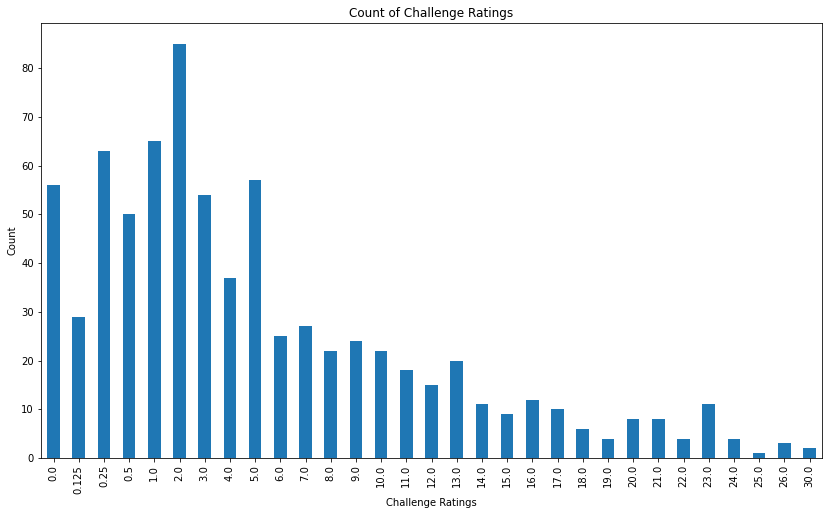

In [37]:
ax = dnd.cr.value_counts().sort_index().plot(kind='bar', figsize=(14,8),title="Count of Challenge Ratings")
ax.set_xlabel("Challenge Ratings")
ax.set_ylabel("Count")
ax

For our machine learning models we'll need to convert the features and targets to numpy arrays.

In [38]:
X = features.to_numpy()
y = target.to_numpy()

Since not all models can take real-numbered targets, we also create a shifted target vector that converts the fractional challenge ratings into the lowest-valued integers and shift the rest of the challenge ratings to accommodate them.

In [39]:
y_shift = []
for i in y:
    if i == .125:
        y_shift.append(1)
    elif i == .25:
        y_shift.append(2)
    elif i == .5:
        y_shift.append(3)
    else:
        y_shift.append(i+3)

In addition to using the whole dataset, we thought that it would be interesting to partition the dataset into different categories and test how much influence each category had. When examining the data, three main partitions stood out: general traits, mobility capabilities, and ability scores. To examine their individual impacts we created an array of modified observations with different combinations of these categories.

In [40]:
traits = ["size", "type", "alignment", "legendary"]
mobility = ["speed", "swim", "climb", "fly", "burrow"]
abilityscore = ["ac", "hp","strength", "dex", "con", "intel", "wis", "cha"]

names = ["No traits", "No mobility", "No ability score", "Only traits", "Only mobility", "Only ability score"]
X_mod = [features.drop(columns=traits)]
X_mod.append(features.drop(columns=mobility))
X_mod.append(features.drop(columns=abilityscore))
X_mod.append(features.drop(columns=mobility+abilityscore))
X_mod.append(features.drop(columns=abilityscore+traits))
X_mod.append(features.drop(columns=traits+mobility))

# Testing Tools

To run our experiments, we created a helper function that takes a model, the observations, target values, and a number of trials to run. This allowed us to easily run experiments per model and find an average score for them.

In [41]:
def test_model(model, X, y, trials):
    test = []
    train = []
    for i in range(trials):
        X_train, X_test, y_train, y_test = train_test_split(X, y)    
        model.fit(X_train, y_train)
        train.append(model.score(X_train, y_train))
        test.append(model.score(X_test, y_test))
    return (np.mean(train), np.mean(test))

# wrapper for nice printing, discarding the return
def print_test_model(model, X, y, trials):
    print_test_model2(model, X, y, trials)

# wrapper for nice printing, with return value
def print_test_model2(model, X, y, trials):
    train_mean, test_mean = test_model(model, X, y, trials)
    print("Accuracy on training set: {:.5f}".format(train_mean))
    print("Accuracy on test set: {:.5f}\n".format(test_mean))
    return (train_mean, test_mean)

We also created some helper functions to test how the model performs when using the various feature partitions and represent those results graphically. This was mostly to see how effective our humanly-judged partitions would work.

In [42]:
def test_model_mod(model, names, X, y, trials):
    for i in range(len(names)):
        print(names[i])
        print_test_model(model, X[i], y, trials)
        
def graph_model_mod(model, names, X, y, trials):
    acc_test = []
    acc_train = []
    for i in range(len(names)):
        train, test = test_model(model, X[i], y, trials)
        print(names[i])
        print("Accuracy on training set: {:.5f}".format(train))
        print("Accuracy on test set: {:.5f}\n".format(test))
        acc_test.append(test)
        acc_train.append(train)
    index = np.arange(len(names))
    plt.figure(figsize=(20, 10))
    plt.bar(index - .2, acc_train, color = 'blue', width=.4, label="Train")
    plt.bar(index+ .2, acc_test, color = 'orange', width=.4, label="Test")
    plt.xticks(index, names)
    plt.yticks([i*.05 for i in range(20)])
    plt.legend()
    plt.show()

Lastly, we created functions to determine which targets the model missed. Instead of running multiple trials, these functions run a model just once. Note that the find_margin function is intended to give a picture of how inaccurate the incorrect predictions are as opposed to how inaccurate the model as a whole is, making it slightly different from a loss function.

In [43]:
# Returns an array of (predict, true) pairs for all misclassifications
def find_missed(model, X, y):
    y_pred = model.predict(X)
    return np.array([[y_pred[i], y[i]] for i in range(len(y)) if y_pred[i] != y[i] ])
        
def test_missed_model(model, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y)    
    model.fit(X_train, y_train)
    train = model.score(X_train, y_train)
    test = model.score(X_test, y_test)
    
    train_missed = find_missed(model, X_train, y_train)
    test_missed = find_missed(model, X_test, y_test)
    
    return (train, train_missed, test, test_missed)

# Finds the average margin of error for a model
def find_margin(missed):
    margin = 0
    for pred, true in missed:
        margin += abs(pred-true)
    return margin/len(missed)

# Helper print functions #

# Print first n incorrect predictions
def print_missed(missed, n):
    print("Number of incorrect predictions: {}".format(len(missed)))
    print("Average margin of error: {}".format(find_margin(missed)))
    for pred, true in missed[:n]:
        print("Predicted {:.5f}, was {}".format(pred, true))
    print()
    
def print_test_missed_model(model, X, y, n):
    train, train_missed, test, test_missed = test_missed_model(model, X, y)
    print("Accuracy on training set: {:.5f}".format(train))
    print_missed(train_missed, n)
    print("Accuracy on test set: {:.5f}".format(test))
    print_missed(test_missed, n)

For each model family, we start by running the test_model function on all the features to create a baseline for expected accuracy. Next, we run the missed functions to get an idea of what the model predicts incorrectly. After that, we experiment with different model parameters as applicable. Finally, we run the model against the different feature partitions to see if those have any influence.

# KNN Classification and Regression

As a baseline, we first started by trying to use knn classification and regression schemes. Let's start with trying out classification. Since knn classification cannot use continuous target values, we had to use the shifted targets.

In [44]:
knn = KNeighborsClassifier(5)
print_test_model(knn, X, y_shift, 100)

Accuracy on training set: 0.47743
Accuracy on test set: 0.26555



Ouch. Not good. Let's take a look at some of the misclassifications.

In [45]:
knn_reg = KNeighborsClassifier(5)
print_test_missed_model(knn, X, y_shift, 10)

Accuracy on training set: 0.48687
Number of incorrect predictions: 293
Average margin of error: 2.6109215017064846
Predicted 8.00000, was 11.0
Predicted 5.00000, was 2.0
Predicted 11.00000, was 8.0
Predicted 23.00000, was 22.0
Predicted 5.00000, was 4.0
Predicted 3.00000, was 4.0
Predicted 12.00000, was 14.0
Predicted 26.00000, was 29.0
Predicted 12.00000, was 8.0
Predicted 9.00000, was 15.0

Accuracy on test set: 0.25131
Number of incorrect predictions: 143
Average margin of error: 2.5874125874125875
Predicted 3.00000, was 6.0
Predicted 5.00000, was 3.0
Predicted 4.00000, was 6.0
Predicted 7.00000, was 6.0
Predicted 24.00000, was 25.0
Predicted 10.00000, was 16.0
Predicted 22.00000, was 23.0
Predicted 3.00000, was 1.0
Predicted 8.00000, was 10.0
Predicted 13.00000, was 17.0



Pretty significant number of misclassifications and a high margin of error. Let's see how regression fares.

In [46]:
knn_reg = KNeighborsRegressor(5)
print_test_model(knn_reg, X, y, 100)

Accuracy on training set: 0.93170
Accuracy on test set: 0.89380



Already that looks much better. Let's see what the incorrect predictions are like this time.

In [47]:
knn_reg = KNeighborsRegressor(5)
print_test_missed_model(knn_reg, X, y, 10)

Accuracy on training set: 0.92833
Number of incorrect predictions: 550
Average margin of error: 1.0784090909090904
Predicted 0.42500, was 0.25
Predicted 1.00000, was 0.5
Predicted 13.60000, was 13.0
Predicted 0.10000, was 0.25
Predicted 16.20000, was 21.0
Predicted 1.05000, was 2.0
Predicted 2.80000, was 4.0
Predicted 3.60000, was 4.0
Predicted 11.60000, was 16.0
Predicted 14.60000, was 12.0

Accuracy on test set: 0.91559
Number of incorrect predictions: 185
Average margin of error: 1.2094594594594597
Predicted 0.30000, was 0.5
Predicted 1.50000, was 0.25
Predicted 1.15000, was 2.0
Predicted 0.45000, was 0.5
Predicted 10.40000, was 8.0
Predicted 0.15000, was 0.125
Predicted 12.00000, was 16.0
Predicted 15.60000, was 17.0
Predicted 2.60000, was 2.0
Predicted 13.80000, was 15.0



Note that we have many more incorrect predictions, but the margin of error for misclassifications has decreased by half. This reveals why classification schemes are less appropriate for our task. Classification actually forces more correct predictions due to being non-continuous by nature, but the majority of misclassifications are too distant to be "rounded" to correctness. Regression on the other hand doesn't look for exactness but rather closeness, and since the incorrect predictions are on average pretty close the model still scores pretty highly.

Since regression is more appropriate for determining challenge rating, we choose to focus on regression model families for the rest of our experiments. But first, let's see if we can improve the knn results by changing the number of neighbors.

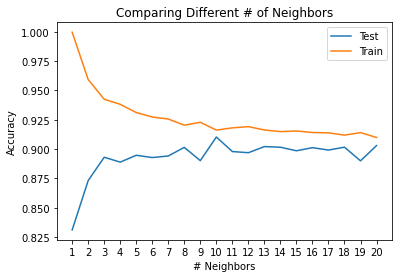

Best pos: 10
Best test mean: 0.903023373906491


In [48]:
test_max = 0
best_pos = 0

ave_test = []
ave_train = []
neighbors = []

for i in range(1,21):
    knn_reg = KNeighborsRegressor(i)
    train_mean, test_mean = test_model(knn_reg, X, y, 20)
    ave_test.append(test_mean)
    ave_train.append(train_mean)
    neighbors.append(i)
    if (test_mean > test_max):
        test_max = test_mean
        best_pos = i

plt.plot(neighbors, ave_test, label="Test")
plt.plot(neighbors, ave_train, label="Train")
plt.title("Comparing Different # of Neighbors")
plt.xlabel("# Neighbors")
plt.ylabel("Accuracy")
plt.xticks([i for i in range(1,21)])
plt.legend()
plt.show()

print("Best pos: {}".format(best_pos))
print("Best test mean: {}".format(test_mean))

Repeating this test indicated that the best results typically occur between 12 and 18 neighbors. Since the accuracy was pretty consistent across tests, we'll split the difference and use 15. Now let's test this against the different partitions.

No traits
Accuracy on training set: 0.91885
Accuracy on test set: 0.90377

No mobility
Accuracy on training set: 0.92036
Accuracy on test set: 0.90471

No ability score
Accuracy on training set: 0.32864
Accuracy on test set: 0.21980

Only traits
Accuracy on training set: 0.46559
Accuracy on test set: 0.38382

Only mobility
Accuracy on training set: 0.23290
Accuracy on test set: 0.17255

Only ability score
Accuracy on training set: 0.92252
Accuracy on test set: 0.90973



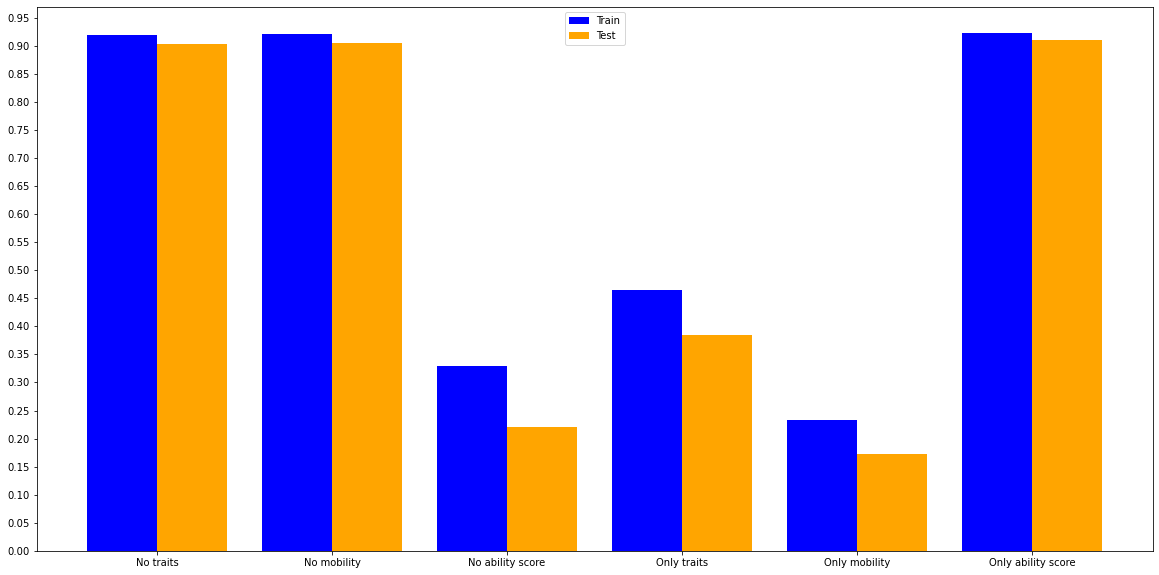

In [49]:
knn_reg = KNeighborsRegressor(15)
graph_model_mod(knn_reg, names, X_mod, y, 100)

Unsurprisingly, ability scores are the main contributing factor towards predicting the challenge rating.

# Linear Regression

Our next set of tests uses the linear regression model. 

In [50]:
lr = LinearRegression()
print_test_model(lr, X, y, 100)

Accuracy on training set: 0.90486
Accuracy on test set: 0.89345



This ran much faster compared to knn regression, but had a slight hit to accuracy. Now to check the missed predictions:

In [51]:
lr = LinearRegression()
print_test_missed_model(lr, X, y, 10)

Accuracy on training set: 0.89893
Number of incorrect predictions: 571
Average margin of error: 1.3919344428484561
Predicted 6.12070, was 8.0
Predicted 0.45002, was 0.125
Predicted 2.34255, was 2.0
Predicted 5.86576, was 7.0
Predicted 3.98808, was 2.0
Predicted 0.54864, was 0.5
Predicted 19.01350, was 21.0
Predicted 3.16730, was 3.0
Predicted 1.35656, was 2.0
Predicted 4.31948, was 5.0

Accuracy on test set: 0.91465
Number of incorrect predictions: 191
Average margin of error: 1.3196434726248483
Predicted 2.56055, was 0.0
Predicted 1.57784, was 4.0
Predicted 0.35026, was 0.0
Predicted 6.61952, was 7.0
Predicted 6.21211, was 6.0
Predicted 3.20410, was 3.0
Predicted 13.47977, was 17.0
Predicted 14.88806, was 21.0
Predicted 24.13398, was 26.0
Predicted 5.17169, was 7.0



The main observation here is that knn regression had fewer incorrect predictions compared to linear regression. This is likely due to knn regression having less decimal precision, allowing for more of its predictions to fall on exact target values than linear regression.

And now for the modified features:

No traits
Accuracy on training set: 0.90324
Accuracy on test set: 0.89427

No mobility
Accuracy on training set: 0.90059
Accuracy on test set: 0.88915

No ability score
Accuracy on training set: 0.45433
Accuracy on test set: 0.43231

Only traits
Accuracy on training set: 0.42843
Accuracy on test set: 0.42057

Only mobility
Accuracy on training set: 0.19869
Accuracy on test set: 0.18255

Only ability score
Accuracy on training set: 0.90011
Accuracy on test set: 0.88990



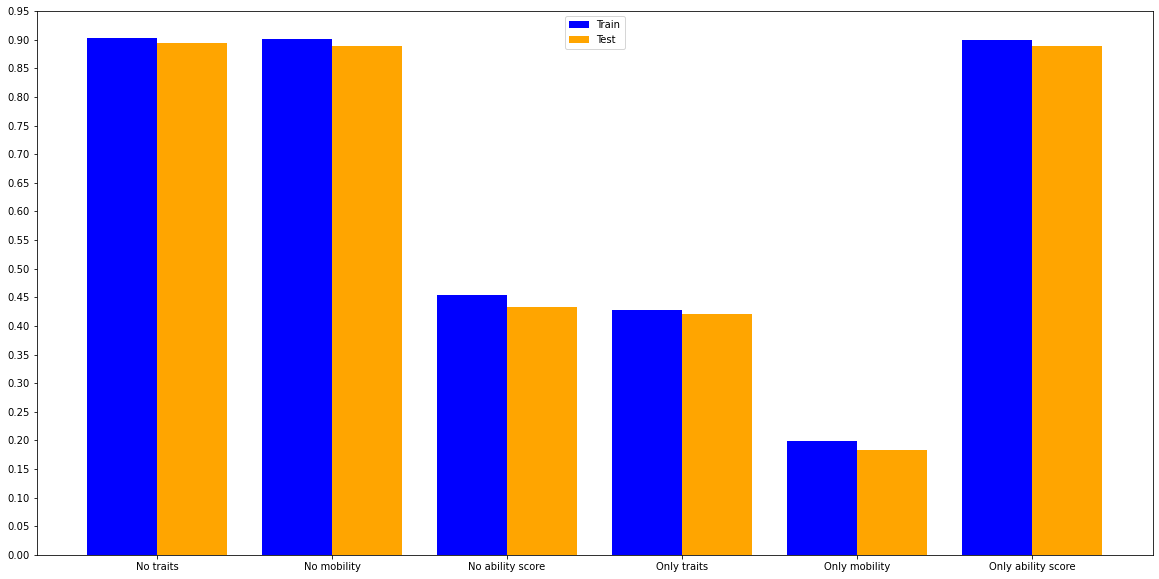

In [52]:
lr = LinearRegression()
graph_model_mod(lr, names, X_mod, y, 100)

The main difference here is that the "no ability score" case scored decently higher compared to knn. Running these in sequence also highlighted the performance discrepancy between the two models, with linear regression running much faster.

# MLP Regression

We now move on to the multilevel perception model. Before we run the tests, we're going to ignore warnings. The MLPRegressor will warn us whenever the model doesn't converge, which gets really distracting. Later we'll adjust the maximum number of iterations for the model, which can also eliminate the convergence warnings, but for presentation purposes we'll create the filter beforehand.

In [53]:
import warnings
warnings.filterwarnings('ignore')

Now to actually test the MLP. This was the slowest to run of them all, so we had to reduce the number of trials to get results in a reasonable amount of time. As a consequence there was some more variance compared to when we ran trials on the other models, but MLPs still had the highest accuracy overall.

In [54]:
mlp = MLPRegressor()
print_test_model(mlp, X, y, 20)

Accuracy on training set: 0.94903
Accuracy on test set: 0.92273



It's a slight improvement over the other models. Let's see what it gets wrong...

In [55]:
mlp = MLPRegressor()
print_test_missed_model(mlp, X, y, 10)

Accuracy on training set: 0.95187
Number of incorrect predictions: 571
Average margin of error: 0.9940559635585778
Predicted 2.19891, was 2.0
Predicted 2.80881, was 2.0
Predicted 4.32781, was 5.0
Predicted 24.66568, was 24.0
Predicted 4.59842, was 3.0
Predicted 13.34775, was 14.0
Predicted 2.58688, was 3.0
Predicted 6.90749, was 6.0
Predicted 2.95321, was 4.0
Predicted 0.36250, was 1.0

Accuracy on test set: 0.91338
Number of incorrect predictions: 191
Average margin of error: 1.2967483980482157
Predicted 9.16060, was 5.0
Predicted 17.65259, was 16.0
Predicted 7.54698, was 9.0
Predicted 1.21513, was 1.0
Predicted 4.73294, was 3.0
Predicted 10.31386, was 10.0
Predicted 4.06822, was 5.0
Predicted 0.36572, was 0.5
Predicted 3.73243, was 3.0
Predicted -0.08390, was 1.0



We can see that the incorrect predictions are closer than the other two models. Much like linear regression there's almost no correct predictions, but the incorrect predictions are closer overall and allow for the model to score more highly.

It's a good baseline overall, but let's see if we can improve it by fiddling with some parameters. Many are solver-specific, but the following are universal parameters that we can adjust. First, the number of hidden layers generally improved the training accuracy, but had a slight downward trend for test accuracy.

Hidden layers: [100]
Accuracy on training set: 0.94959
Accuracy on test set: 0.91298

Hidden layers: [100, 100]
Accuracy on training set: 0.96017
Accuracy on test set: 0.90943

Hidden layers: [100, 100, 100]
Accuracy on training set: 0.96654
Accuracy on test set: 0.91019

Hidden layers: [100, 100, 100, 100]
Accuracy on training set: 0.96909
Accuracy on test set: 0.90726

Hidden layers: [100, 100, 100, 100, 100]
Accuracy on training set: 0.96965
Accuracy on test set: 0.91419



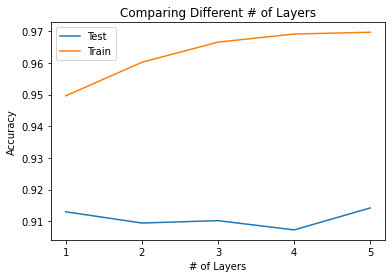

In [56]:
# Default is [100]
n = 6
hidden_layer_count = [[100]*i for i in range(1, n)]

ave_test = []
ave_train = []

for s in hidden_layer_count:
    print("Hidden layers: {}".format(s))
    mlp = MLPRegressor(hidden_layer_sizes=s)
    train, test = print_test_model2(mlp, X, y, 20)
    ave_test.append(test)
    ave_train.append(train)

plt.plot([i for i in range(1, n)], ave_test, label="Test")
plt.plot([i for i in range(1, n)], ave_train, label="Train")
plt.title("Comparing Different # of Layers")
plt.xlabel("# of Layers")
plt.ylabel("Accuracy")
plt.xticks([i for i in range(1, n)])
plt.legend()
plt.show()

Increasing the number of hidden units in a layer had more variance, but there was still a general upwards trend for training accuracy. Test accuracy was somewhat inconsistent but seemed to improve with larger layers.

Hidden layer: [100]
Accuracy on training set: 0.94997
Accuracy on test set: 0.91169

Hidden layer: [200]
Accuracy on training set: 0.95498
Accuracy on test set: 0.92368

Hidden layer: [300]
Accuracy on training set: 0.96013
Accuracy on test set: 0.92416

Hidden layer: [400]
Accuracy on training set: 0.96165
Accuracy on test set: 0.92307

Hidden layer: [500]
Accuracy on training set: 0.95997
Accuracy on test set: 0.92528

Hidden layer: [600]
Accuracy on training set: 0.96099
Accuracy on test set: 0.92667

Hidden layer: [700]
Accuracy on training set: 0.95953
Accuracy on test set: 0.92767

Hidden layer: [800]
Accuracy on training set: 0.95747
Accuracy on test set: 0.92018

Hidden layer: [900]
Accuracy on training set: 0.96331
Accuracy on test set: 0.92211

Hidden layer: [1000]
Accuracy on training set: 0.96393
Accuracy on test set: 0.92660



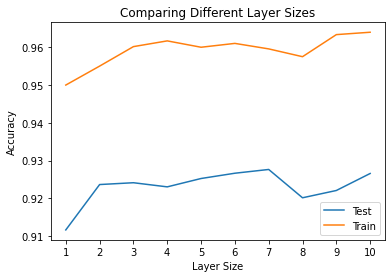

In [57]:
# Default is [100]
n = 11
hidden_layer_sizes = [[100*i] for i in range(1, n)]

ave_test = []
ave_train = []

for s in hidden_layer_sizes:
    print("Hidden layer: {}".format(s))
    mlp = MLPRegressor(hidden_layer_sizes=s)
    train, test = print_test_model2(mlp, X, y, 20)
    ave_test.append(test)
    ave_train.append(train)

plt.plot([i for i in range(1, n)], ave_test, label="Test")
plt.plot([i for i in range(1, n)], ave_train, label="Train")
plt.title("Comparing Different Layer Sizes")
plt.xlabel("Layer Size")
plt.ylabel("Accuracy")
plt.xticks([i for i in range(1, n)])
plt.legend()
plt.show()

The default relu activation function works the best.

In [58]:
# Default is relu
activation = ['relu', 'identity', 'logistic', 'tanh']
for a in activation:
    print("Activation: " + a)
    mlp = MLPRegressor(activation=a)
    print_test_model(mlp, X, y, 20)

Activation: relu
Accuracy on training set: 0.94936
Accuracy on test set: 0.92178

Activation: identity
Accuracy on training set: 0.88890
Accuracy on test set: 0.87151

Activation: logistic
Accuracy on training set: 0.90286
Accuracy on test set: 0.86521

Activation: tanh
Accuracy on training set: 0.93037
Accuracy on test set: 0.87082



The default adam solver has the best test accuracy, but lbfgs had better training accuracy. The sgd solver doesn't work at all though.

In [59]:
# Default is adam
solvers = ['adam', 'lbfgs', 'sgd']
for s in solvers:
    print("Solver: " + s)
    mlp = MLPRegressor(solver=s)
    print_test_model(mlp, X, y, 20)

Solver: adam
Accuracy on training set: 0.94959
Accuracy on test set: 0.91537

Solver: lbfgs
Accuracy on training set: 0.95953
Accuracy on test set: 0.91238

Solver: sgd
Accuracy on training set: -14.15155
Accuracy on test set: -13.27592



Adjusting the alpha had some fluxuations but didn't result in any significant improvement. Setting alpha too high did cause a dropoff in accuracy though.

Alpha: 0.0001
Accuracy on training set: 0.94865
Accuracy on test set: 0.91759

Alpha: 0.001
Accuracy on training set: 0.94922
Accuracy on test set: 0.92185

Alpha: 0.01
Accuracy on training set: 0.94992
Accuracy on test set: 0.91468

Alpha: 0.1
Accuracy on training set: 0.94814
Accuracy on test set: 0.91889

Alpha: 1.0
Accuracy on training set: 0.94981
Accuracy on test set: 0.91409

Alpha: 10.0
Accuracy on training set: 0.95028
Accuracy on test set: 0.92057

Alpha: 100.0
Accuracy on training set: 0.94269
Accuracy on test set: 0.91760

Alpha: 1000.0
Accuracy on training set: 0.91539
Accuracy on test set: 0.90864



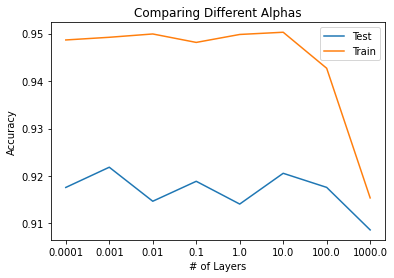

In [60]:
# Default is 0.0001
n = 8
alphas = [0.0001 * (10**i) for i in range(n)]

ave_test = []
ave_train = []

for a in alphas:
    print("Alpha: {}".format(a))
    mlp = MLPRegressor(alpha=a)
    train, test = print_test_model2(mlp, X, y, 20)
    ave_test.append(test)
    ave_train.append(train)

plt.plot([i for i in range(n)], ave_test, label="Test")
plt.plot([i for i in range(n)], ave_train, label="Train")
plt.title("Comparing Different Alphas")
plt.xlabel("# of Layers")
plt.ylabel("Accuracy")
plt.xticks([i for i in range(n)], alphas)
plt.legend()
plt.show()

Lastly, increasing the iteration count to allow for convergence trended towards higher overall accuracy, though this seems to be more of a question of consistency than actual improvement.

count: 200
Accuracy on training set: 0.94722
Accuracy on test set: 0.92082

count: 400
Accuracy on training set: 0.95830
Accuracy on test set: 0.92377

count: 600
Accuracy on training set: 0.95990
Accuracy on test set: 0.91809

count: 800
Accuracy on training set: 0.96177
Accuracy on test set: 0.92065

count: 1000
Accuracy on training set: 0.95954
Accuracy on test set: 0.91945



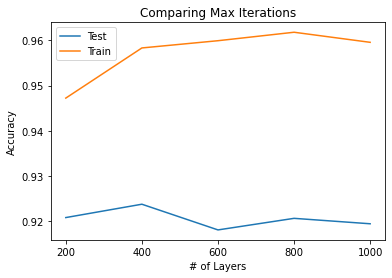

In [61]:
# Default is 200
n = 6
count = [200 * i for i in range(1, n)]

ave_test = []
ave_train = []

for c in count:
    print("count: {}".format(c))
    mlp = MLPRegressor(max_iter=c)
    train, test = print_test_model2(mlp, X, y, 20)
    ave_test.append(test)
    ave_train.append(train)

plt.plot([i for i in range(1, n)], ave_test, label="Test")
plt.plot([i for i in range(1, n)], ave_train, label="Train")
plt.title("Comparing Max Iterations")
plt.xlabel("# of Layers")
plt.ylabel("Accuracy")
plt.xticks([i for i in range(1, n)], count)
plt.legend()
plt.show()

As a whole, it looks like changing individual parameters can only improve accuracy by around 1% at most. While we could combine and fine-tune the parameters to eek out more overall accuracy, it seems unlikely that it'll improve by much individual factors weren't substantial. The most likely change would be the amount of time it takes to process.

Let's return to the default parameters and check our partitioned features.

No traits
Accuracy on training set: 0.94363
Accuracy on test set: 0.92105

No mobility
Accuracy on training set: 0.94007
Accuracy on test set: 0.93413

No ability score
Accuracy on training set: 0.54285
Accuracy on test set: 0.43029

Only traits
Accuracy on training set: 0.51322
Accuracy on test set: 0.48172

Only mobility
Accuracy on training set: 0.24704
Accuracy on test set: 0.18997

Only ability score
Accuracy on training set: 0.93290
Accuracy on test set: 0.93132



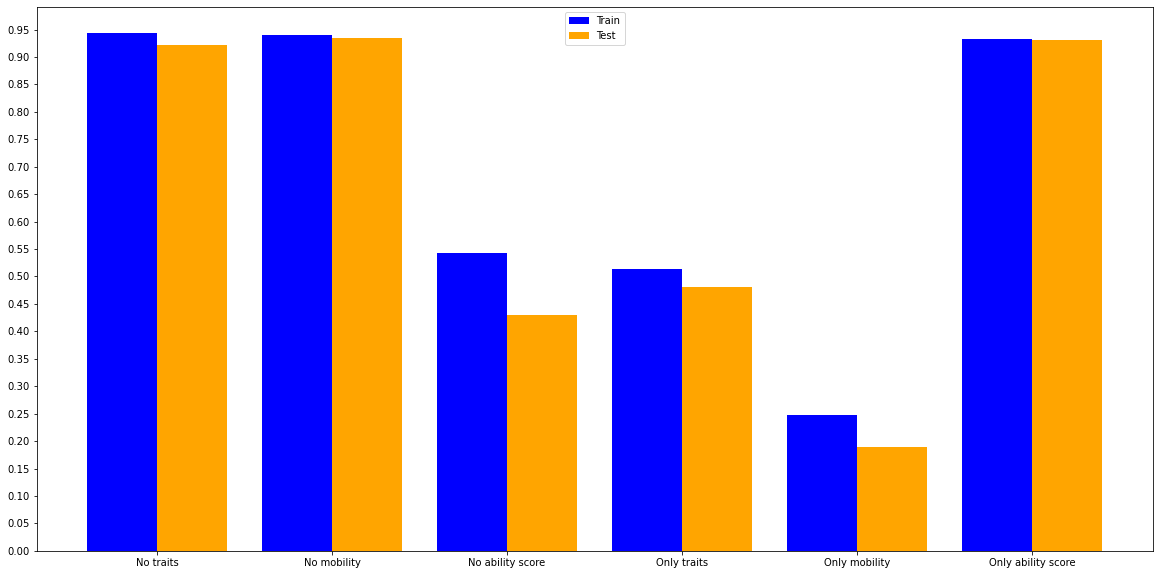

In [62]:
mlp = MLPRegressor()
graph_model_mod(mlp, names, X_mod, y, 10)

It scored slightly higher on the partitions with no ability score, but nothing too substantial here.

# Homebrew Tests

Now to test how well our model works in the wild. First, we need our text-to-numeric mapping since we'll be reading off actual monsters, which are stored below.

In [63]:
sizes = {"tiny": 0, "small": 1, "medium": 2, "large": 3, "huge": 4, "gargantuan": 5}

types = {'humanoid (aarakocra)': 0,
 'humanoid (any race)': 1,
 'aberration': 2,
 'monstrosity': 3,
 'undead': 4,
 'dragon': 5,
 'ooze': 6,
 'elemental': 7,
 'humanoid (dwarf)': 8,
 'fiend (demon)': 9,
 'beast': 10,
 'fiend (devil)': 11,
 'construct': 12,
 'fey': 13,
 'fiend (yugoloth)': 14,
 'plant': 15,
 'monstrosity (titan)': 16,
 'undead (titan)': 17,
 'fey (elf)': 18,
 'fiend (shapechanger)': 19,
 'humanoid (human)': 20,
 'humanoid (goblinoid)': 21,
 'humanoid (bullywug)': 22,
 'fiend': 23,
 'giant': 24,
 'giant (cloud giant)': 25,
 'celestial': 26,
 'aberration (shapechanger)': 27,
 'humanoid (gnome)': 28,
 'humanoid (shapechanger)': 29,
 'humanoid (derro)': 30,
 'monstrosity (shapechanger)': 31,
 'humanoid (saurial)': 32,
 'humanoid (elf)': 33,
 'celestial (titan)': 34,
 'giant (fire giant)': 35,
 'humanoid (firenewt)': 36,
 'humanoid (gnoll)': 37,
 'giant (frost giant)': 38,
 'humanoid': 39,
 'humanoid (gith)': 40,
 'fiend (gnoll)': 41,
 'fiend (demon, shapechanger)': 42,
 'humanoid (grimlock)': 43,
 'humanoid (grung)': 44,
 'fiend (devil, shapechanger)': 45,
 'humanoid (kenku)': 46,
 'humanoid (kobold)': 47,
 'humanoid (kuo-toa)': 48,
 'humanoid (lizardfolk)': 49,
 'construct (inevitable)': 50,
 'humanoid (meazel)': 51,
 'humanoid (merfolk)': 52,
 'giant (hill giant)': 53,
 'humanoid (nagpa)': 54,
 'humanoid (orc)': 55,
 'humanoid (quaggoth)': 56,
 'humanoid (sahuagin)': 57,
 'giant (stone giant)': 58,
 'giant (storm giant)': 59,
 'undead (shapechanger)': 60,
 'swarm of Tiny beasts': 61,
 'humanoid (tabaxi)': 62,
 'fiend (demon, orc)': 63,
 'humanoid (thri-kreen)': 64,
 'humanoid (tortle)': 65,
 'humanoid (troglodyte)': 66,
 'humanoid (human, shapechanger)': 67,
 'humanoid (xvart)': 68,
 'monstrosity (shapechanger, yuan-ti)': 69,
 'humanoid (yuan-ti)': 70}

aligns = {'neutral good': 0,
 'any alignment': 1,
 'lawful evil': 2,
 'chaotic evil': 3,
 'neutral evil': 4,
 'chaotic good': 5,
 'lawful good': 6,
 'unaligned': 7,
 'neutral': 8,
 'lawful neutral': 9,
 'any evil alignment': 10,
 'any non-good alignment': 11,
 'chaotic neutral': 12,
 'any non-lawful alignment': 13,
 'any chaotic alignment': 14,
 'neutral good (50 %) or neutral evil (50 %)': 15,
 'chaotic good (75 %) or neutral evil (25 %)': 16}

And here's a convenience function to create a monster datapoint from its characteristics. The main benefit of this is that it converts the textual parameters to their mapped numeric values for us.

In [64]:
def make_monster(size,m_type,alignment,ac,hp,speed,swim,climb,fly,burrow,strength,dex,con,intel,wis,cha,legendary):
    return [sizes[size],types[m_type],aligns[alignment],ac,hp,speed,swim,climb,fly,burrow,strength,dex,con,intel,wis,cha,legendary]

Let's try it out! We chose five homebrew monsters made by the community and tested them against our models.

Sources:

pirate: https://www.dndbeyond.com/monsters/28629-pirate

goblin shaman: https://www.dndbeyond.com/monsters/198574-goblin-shaman

phoenix: https://www.dndbeyond.com/monsters/36182-phoenix

cthulhu: https://www.dndbeyond.com/monsters/20188-cthulhu

zombie dragon: https://www.dndbeyond.com/monsters/32839-zombie-dragon

In [65]:
pirate = make_monster('medium','humanoid','any non-good alignment',11,7,30,0,0,0,0,12,13,10,7,7,5,0)
goblin_shaman = make_monster('small','humanoid (goblinoid)','neutral evil',12,15,30,0,0,0,0,8,14,10,14,8,8,0)
phoenix=make_monster('huge','monstrosity','lawful good',15,73,20,0,0,80,0,20,20,18,12,10,9,0)
cthulhu=make_monster('gargantuan','monstrosity','lawful evil',19,900,20,30,0,50,0,30,16,25,28,18,10,1)
zombie_dragon=make_monster('large','undead','neutral evil',16,150,40,40,0,80,0,19,14,18,15,11,9,0)

monsters = [pirate, goblin_shaman, phoenix, cthulhu, zombie_dragon]
trues = [0.5,0.5,6,30,6]
names = ['pirate','goblin shaman','phoenix','cthulhu','zombie dragon']

model_names = ["knn", "linear regression", "mlp"]
models = [KNeighborsRegressor(15), LinearRegression(), MLPRegressor()]
for m,n in zip(models, model_names):
    print(n)
    print_test_model(m, X, y, 1)
    preds = m.predict(monsters)
    for p, t, n in zip(preds, trues, names):
        print(n + ": predicted {:.5f}, was {}".format(p,t))
    print()

knn
Accuracy on training set: 0.91373
Accuracy on test set: 0.90980

pirate: predicted 0.50833, was 0.5
goblin shaman: predicted 0.48333, was 0.5
phoenix: predicted 4.73333, was 6
cthulhu: predicted 22.93333, was 30
zombie dragon: predicted 10.00000, was 6

linear regression
Accuracy on training set: 0.90625
Accuracy on test set: 0.88994

pirate: predicted -0.98930, was 0.5
goblin shaman: predicted 0.69686, was 0.5
phoenix: predicted 4.65864, was 6
cthulhu: predicted 49.63234, was 30
zombie dragon: predicted 7.97098, was 6

mlp
Accuracy on training set: 0.94974
Accuracy on test set: 0.91704

pirate: predicted -0.38654, was 0.5
goblin shaman: predicted 1.19860, was 0.5
phoenix: predicted 3.72566, was 6
cthulhu: predicted 36.39610, was 30
zombie dragon: predicted 8.93566, was 6



Could be better all things considered, but it's not the worst approximations. 

# Conclusions

Unsurprisingly, determining the challenge rating of a DnD monster is a task best suited for regression. Of the models we tested, MLPs performed the best, though all of them performed reasonably well in the 90-95% accuracy range. In all cases, ability scores contributed most to the accuracy of the model.